In [75]:
#!pip install catboost
#!pip install wordcloud
#!pip install xgboost
#!pip install imblearn
#!pip install nltk
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mfval\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data=pd.read_csv('mbti_1.csv', engine='python')
data.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [3]:
data.describe(include='O')

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'I'm feeling SO good right now. I've been maki...
freq    1832                                                  1

In [4]:
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [6]:
# Stratify split to ensure equal distribution of data

train_data,test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)

In [7]:
train_data

type                                              posts
1228  INFP  'We are mandarin speakers.  He receive educati...
1290  ISTP  'Nope.  Not now, not ever.  I'm too busy with ...
6756  ENFJ  'That's the only one I haven't gotten to read ...
1662  INFP  'I used to think that maturity was burning bri...
3338  INFP  'I get typed as both a 4w5 and 5w6 as well but...
...    ...                                                ...
7292  INFP  Haven't posted here in a while. Here was my at...
1086  INFP  'Ok, I'll go first. I'm a 29 year old INFP mal...
7435  ENTJ  'I have dated a few INFJs, including my curren...
1843  INTP  'People who are unable to replace social norms...
2530  ENTP  'Yep! you're right! I agree with you!! i think...

[6940 rows x 2 columns]

In [8]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [9]:
train_data.posts,train_length=clear_text(train_data)

100%|██████████| 6940/6940 [00:02<00:00, 2428.33it/s]


In [10]:
test_data.posts,test_length=clear_text(test_data)

100%|██████████| 1735/1735 [00:00<00:00, 2496.87it/s]


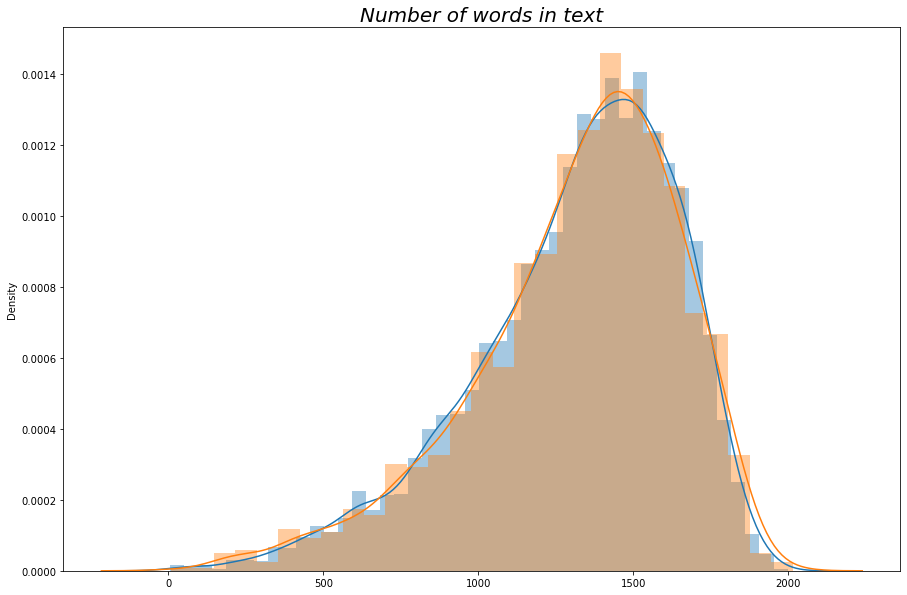

In [11]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

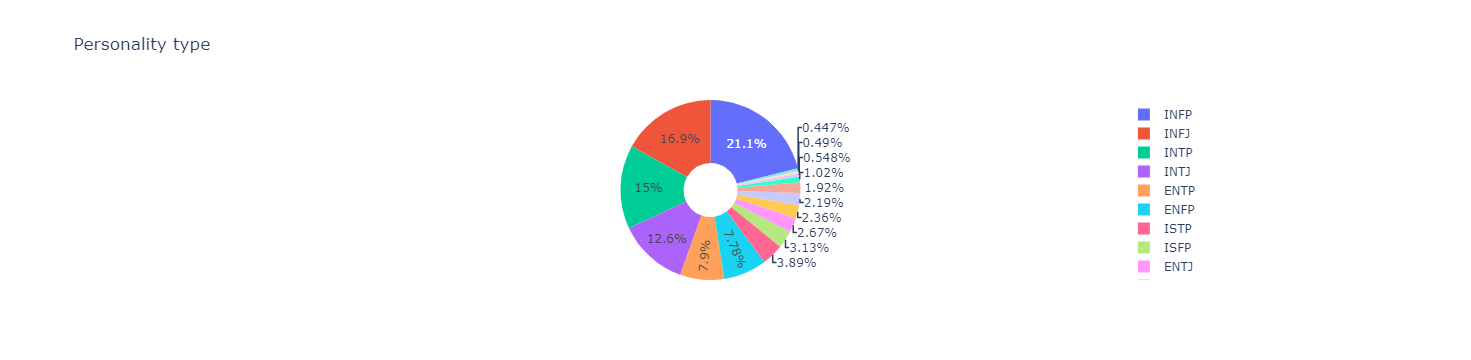

In [12]:
px.pie(train_data,names='type',title='Personality type',hole=0.3)

# Tokenizar


In [13]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [14]:
vectorizer=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x000001B037C68AF0>)

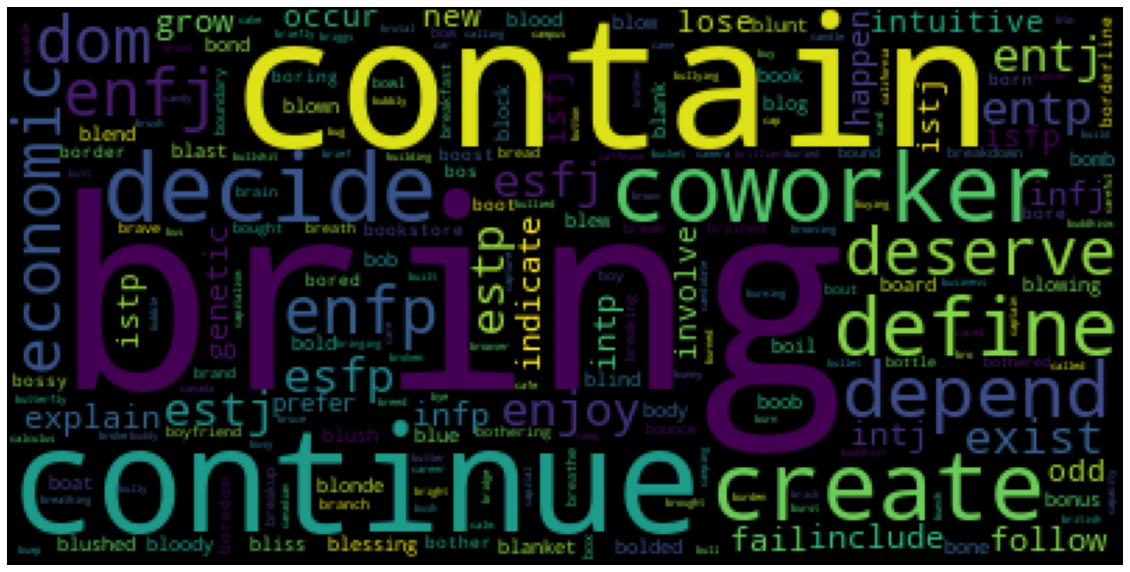

In [15]:
feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [16]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()
total_post=vectorizer.transform(data.posts).toarray()

In [17]:
total_post=vectorizer.transform(data.posts).toarray()

In [18]:
total_post.shape

(8675, 5000)

In [19]:
target_encoder=LabelEncoder()
total_target = target_encoder.fit_transform(data.type)
train_target=target_encoder.fit_transform(train_data.type)
test_target=target_encoder.fit_transform(test_data.type)

In [20]:
total_target = target_encoder.fit_transform(data.type)

# Modelos

### SVC

In [21]:
models_accuracy={}

In [22]:
model_svc=SVC()
model_svc.fit(train_post, train_target)

SVC()

In [23]:
print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.84      0.90       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.56      0.72        34
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.92      0.98      0.95      1465
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [24]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

### logistic regression

In [25]:
model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [26]:
print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

In [27]:
models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

### Multinomial Naive Bayes

In [28]:
model_nb=MultinomialNB()
model_nb.fit(train_post,train_target)

MultinomialNB()

In [29]:
print('train classification report \n ',classification_report(train_target,model_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.90      0.02      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.06      0.11       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.56      1176
        INFP       0.35      0.94      0.52      1465
        INTJ       0.78      0.42      0.54       873
        INTP       0.58      0.64      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       1.00      0.00      0.01       270

    accuracy                           0.46      

In [30]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_nb.predict(test_post))

In [31]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')

# Modelos Total

### SVC

In [32]:
model_svcT=SVC()
model_svcT.fit(total_post, total_target)

SVC()

### logistic regression

In [33]:
model_logT=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_logT.fit(total_post, total_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

### Multinomial Naive Bayes

In [34]:
model_nbT=MultinomialNB()
model_nbT.fit(total_post, total_target)

MultinomialNB()

# Parte The Office

In [35]:
dataoffice = pd.read_csv('officedata.csv')
dataoffice.head()

season  episode  title  scene  speaker  \
0       1        1  Pilot      1  Michael   
1       1        1  Pilot      1      Jim   
2       1        1  Pilot      1  Michael   
3       1        1  Pilot      1      Jim   
4       1        1  Pilot      1  Michael   

                                                line Unnamed: 6  
0  All right Jim. Your quarterlies look very good...        NaN  
1         Oh, I told you. I couldn't close it. So...        NaN  
2  So you've come to the master for guidance? Is ...        NaN  
3         Actually, you called me in here, but yeah.        NaN  
4    All right. Well, let me show you how it's done.        NaN

In [36]:
# Para este caso solamente se usarán estas dos columnas. Linea para el NLP, y speaker
# para saber quien habló y quien resultó con tal personalidad
dataoffice = dataoffice[['speaker','line']]
dataoffice.head()

speaker                                               line
0  Michael  All right Jim. Your quarterlies look very good...
1      Jim         Oh, I told you. I couldn't close it. So...
2  Michael  So you've come to the master for guidance? Is ...
3      Jim         Actually, you called me in here, but yeah.
4  Michael    All right. Well, let me show you how it's done.

In [37]:
dataoffice.describe(include='O')

speaker   line
count     54626  54626
unique      775  47243
top     Michael  Yeah.
freq      10773    418

In [38]:
dataoffice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54626 entries, 0 to 54625
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  54626 non-null  object
 1   line     54626 non-null  object
dtypes: object(2)
memory usage: 853.7+ KB


In [39]:
# Se comienza la limpieza de datos

# Primero se escogen solamente los personajes con 1000+ lineas

dataoffice = dataoffice.loc[dataoffice['speaker'].isin(['Michael','Dwight','Jim',
                                                        'Pam','Andy','Kevin'
                                                        ,'Angela','Erin','Oscar',
                                                        'Ryan', 'Darryl'])]
                      
dataoffice.describe(include='O')

speaker   line
count     40578  40578
unique       11  35330
top     Michael  Yeah.
freq      10773    305

In [40]:
dataoffice['speaker'].value_counts()

Michael    10773
Dwight      6752
Jim         6222
Pam         4973
Andy        3698
Kevin       1535
Angela      1534
Erin        1413
Oscar       1336
Ryan        1182
Darryl      1160
Name: speaker, dtype: int64

<AxesSubplot:>

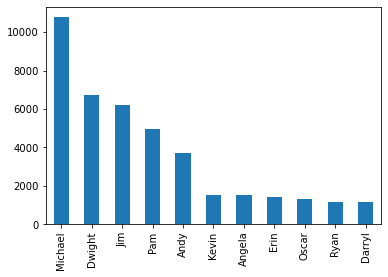

In [41]:
dataoffice['speaker'].value_counts().plot(kind = 'bar')

In [42]:
dataoffice.describe(include='O')

speaker   line
count     40578  40578
unique       11  35330
top     Michael  Yeah.
freq      10773    305

In [43]:
test_dataoffice = dataoffice

In [44]:
def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.line):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length

In [45]:
test_dataoffice.line,testoffice_length=clear_text(dataoffice)

100%|██████████| 40578/40578 [00:00<00:00, 185983.69it/s]


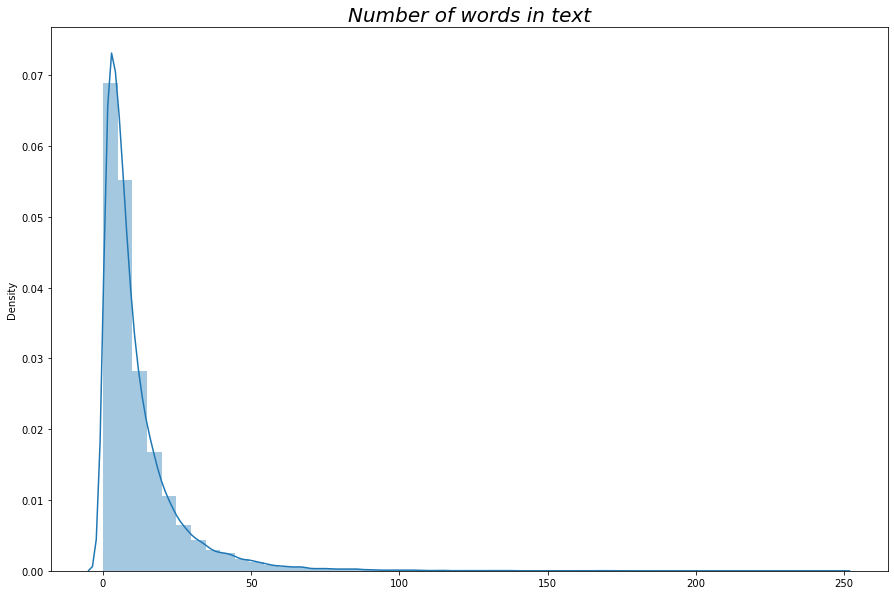

In [73]:
plt.figure(figsize=(15,10))
sns.distplot(testoffice_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.savefig('Number_of_words.png')
plt.show()

In [47]:
vectorizeroffice=TfidfVectorizer( max_features=5000,stop_words='english',tokenizer=Lemmatizer(), )
vectorizeroffice.fit(test_dataoffice.line)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x000001B081579880>)

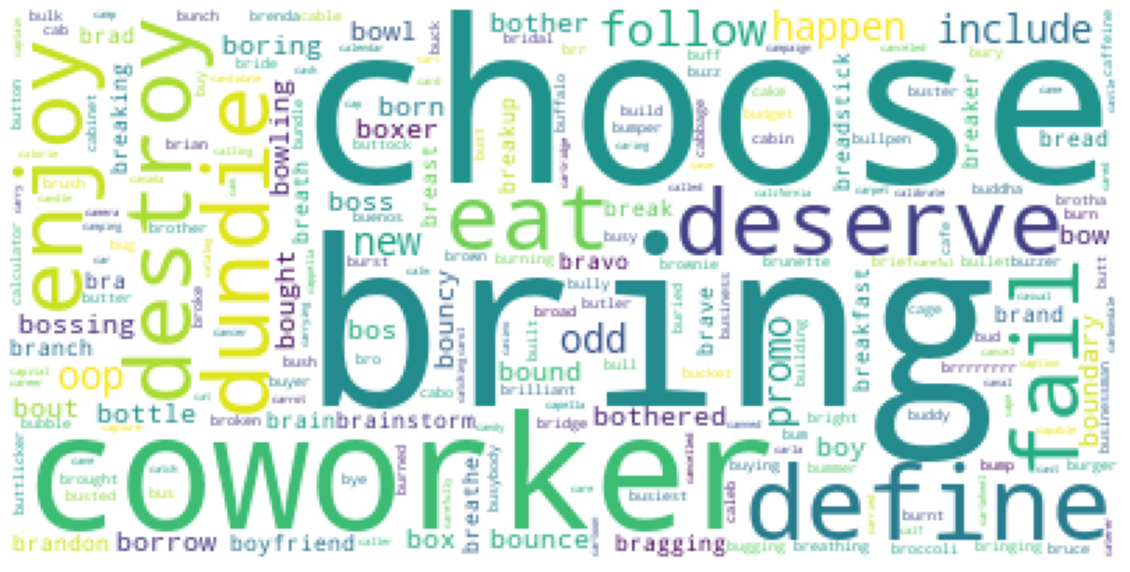

In [48]:
feature_namesoffice=vectorizeroffice.get_feature_names()
wcOffice=WordCloud(background_color="white",max_words=400)
wcOffice.generate(' '.join(word for word in feature_namesoffice[500:3500] ))
plt.figure(figsize=(20,15))
plt.imshow(wcOffice, interpolation='bilinear', aspect='auto')
plt.axis('off')
plt.imshow(wcOffice)

In [49]:
test_postOffice=vectorizeroffice.transform(test_dataoffice.line).toarray()

In [50]:
test_postOffice.shape

(40578, 5000)

### SVC

In [51]:
SVCPredictedOffice = model_svcT.predict(test_postOffice)

In [52]:
df_predictedOffice = pd.DataFrame(SVCPredictedOffice, columns=['personalidad'])
pjs = dataoffice['speaker']
pjs = dataoffice.reset_index()
df_predictedOffice

personalidad
0                10
1                11
2                11
3                10
4                10
...             ...
40573            11
40574            11
40575            10
40576            10
40577            11

[40578 rows x 1 columns]

In [53]:
predictedOfficePjs = pd.concat([df_predictedOffice, pjs['speaker']], axis=1)
predictedOfficePjs['personalidad'] = target_encoder.inverse_transform(predictedOfficePjs['personalidad'])
predictedOfficePjs

personalidad  speaker
0             INTJ  Michael
1             INTP      Jim
2             INTP  Michael
3             INTJ      Jim
4             INTJ  Michael
...            ...      ...
40573         INTP    Oscar
40574         INTP     Erin
40575         INTJ   Darryl
40576         INTJ      Jim
40577         INTP      Pam

[40578 rows x 2 columns]

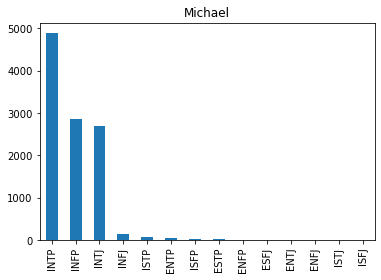

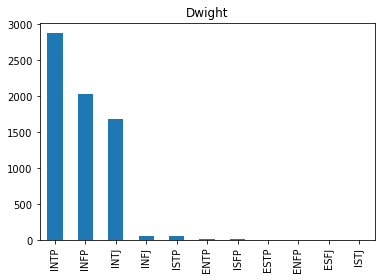

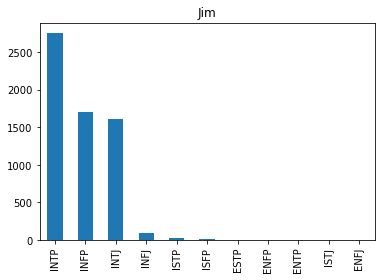

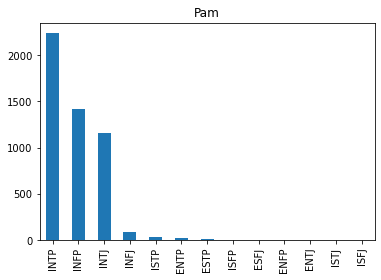

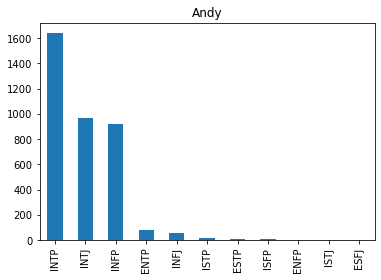

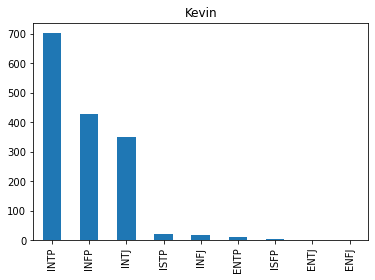

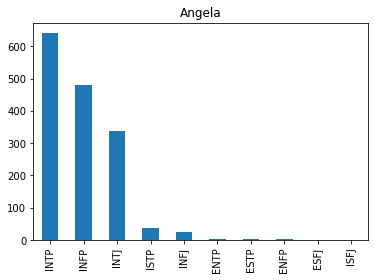

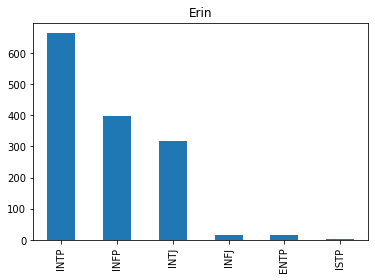

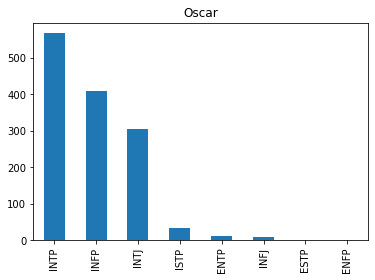

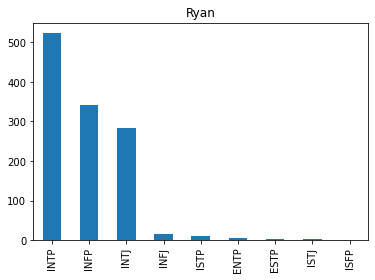

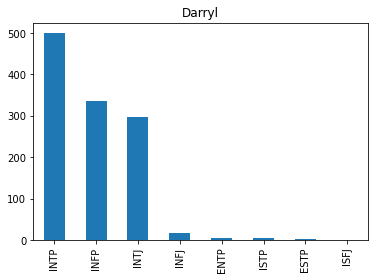

In [54]:
names = ['Michael','Dwight','Jim', 'Pam','Andy','Kevin'
          ,'Angela','Erin','Oscar','Ryan', 'Darryl']
for f in names:
  predictedPj = predictedOfficePjs.loc[predictedOfficePjs['speaker'].isin([f])]
  predictedPj['personalidad'].value_counts().plot(kind = 'bar', title=f)
  plt.show()

In [55]:
cnt_all = np.unique(SVCPredictedOffice, return_counts=True)

In [56]:
pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

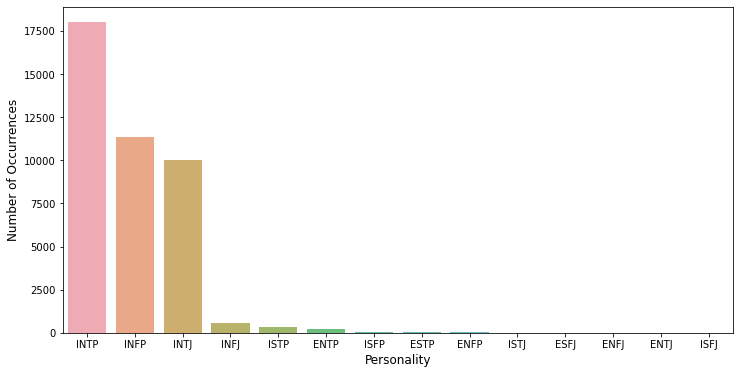

In [57]:
categorias = target_encoder.inverse_transform(pred_df['personality'])
pred_df2 = pred_df
pred_df2['personality'] = target_encoder.inverse_transform(pred_df['personality'])
pred_df2.sort_values('count', ascending=False, inplace=True)
plt.figure(figsize=(12,6))
sns.barplot(pred_df2['personality'], pred_df2['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

### logistic regression

In [58]:
LogPredictedOffice = model_logT.predict(test_postOffice)

In [59]:
df_predictedOffice = pd.DataFrame(LogPredictedOffice, columns=['personalidad'])
pjs = dataoffice['speaker']
pjs = dataoffice.reset_index()
df_predictedOffice

personalidad
0                10
1                10
2                11
3                10
4                10
...             ...
40573            10
40574            11
40575            10
40576            10
40577            10

[40578 rows x 1 columns]

In [60]:
predictedOfficePjs = pd.concat([df_predictedOffice, pjs['speaker']], axis=1)
predictedOfficePjs['personalidad'] = target_encoder.inverse_transform(predictedOfficePjs['personalidad'])
predictedOfficePjs

personalidad  speaker
0             INTJ  Michael
1             INTJ      Jim
2             INTP  Michael
3             INTJ      Jim
4             INTJ  Michael
...            ...      ...
40573         INTJ    Oscar
40574         INTP     Erin
40575         INTJ   Darryl
40576         INTJ      Jim
40577         INTJ      Pam

[40578 rows x 2 columns]

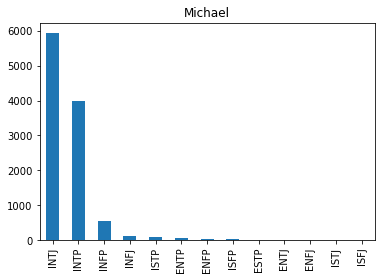

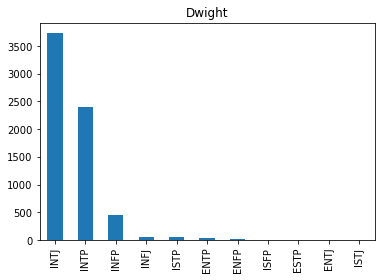

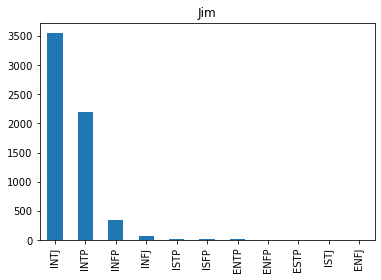

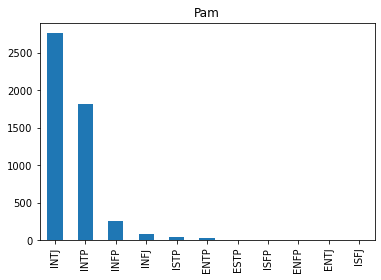

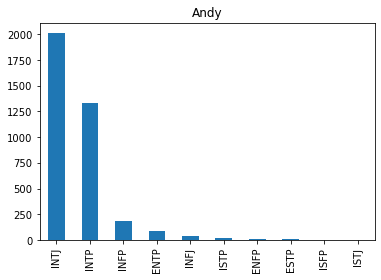

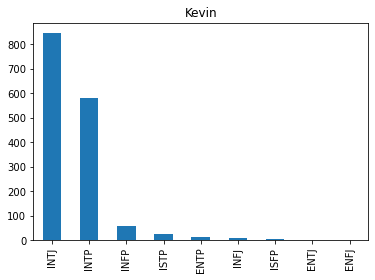

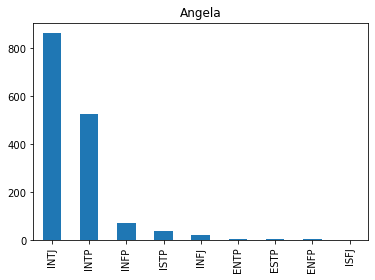

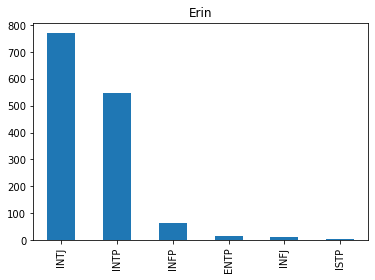

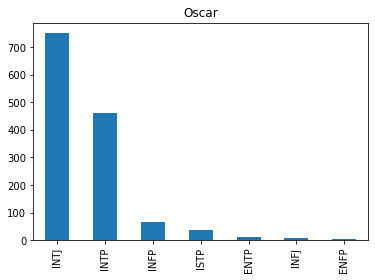

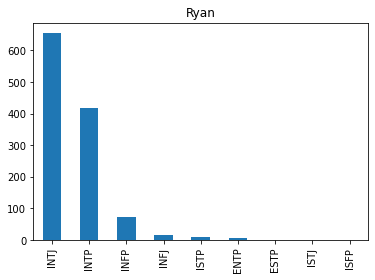

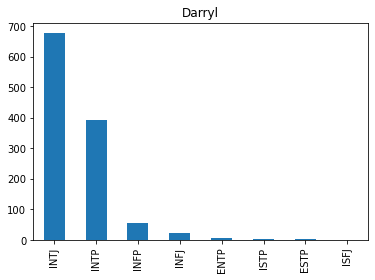

In [61]:
names = ['Michael','Dwight','Jim', 'Pam','Andy','Kevin'
          ,'Angela','Erin','Oscar','Ryan', 'Darryl']
for f in names:
  predictedPj = predictedOfficePjs.loc[predictedOfficePjs['speaker'].isin([f])]
  predictedPj['personalidad'].value_counts().plot(kind = 'bar', title=f)
  plt.show()

In [62]:
cnt_all = np.unique(LogPredictedOffice, return_counts=True)

In [63]:
pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

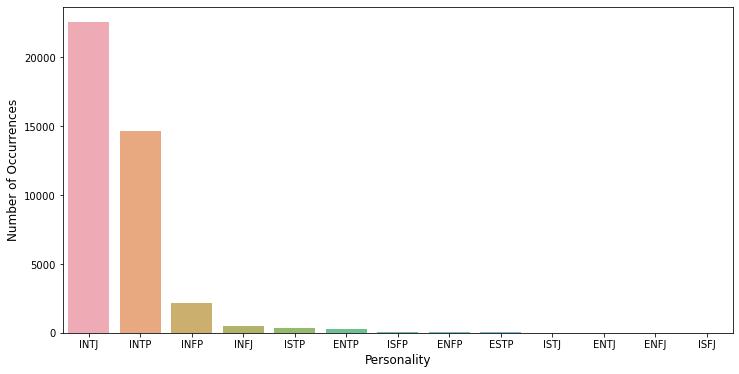

In [64]:
categorias = target_encoder.inverse_transform(pred_df['personality'])
pred_df2 = pred_df
pred_df2['personality'] = target_encoder.inverse_transform(pred_df['personality'])
pred_df2.sort_values('count', ascending=False, inplace=True)
plt.figure(figsize=(12,6))
sns.barplot(pred_df2['personality'], pred_df2['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

### Multinomial Naive Bayes

In [65]:
NbPredictedOffice = model_nbT.predict(test_postOffice)

In [66]:
df_predictedOffice = pd.DataFrame(NbPredictedOffice, columns=['personalidad'])
pjs = dataoffice['speaker']
pjs = dataoffice.reset_index()
df_predictedOffice

personalidad
0                 9
1                 9
2                 9
3                 9
4                 9
...             ...
40573             8
40574             9
40575             9
40576            11
40577             8

[40578 rows x 1 columns]

In [67]:
predictedOfficePjs = pd.concat([df_predictedOffice, pjs['speaker']], axis=1)
predictedOfficePjs['personalidad'] = target_encoder.inverse_transform(predictedOfficePjs['personalidad'])
predictedOfficePjs

personalidad  speaker
0             INFP  Michael
1             INFP      Jim
2             INFP  Michael
3             INFP      Jim
4             INFP  Michael
...            ...      ...
40573         INFJ    Oscar
40574         INFP     Erin
40575         INFP   Darryl
40576         INTP      Jim
40577         INFJ      Pam

[40578 rows x 2 columns]

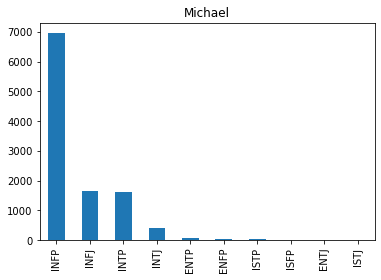

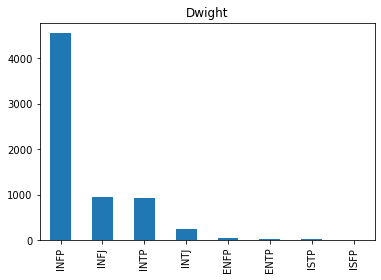

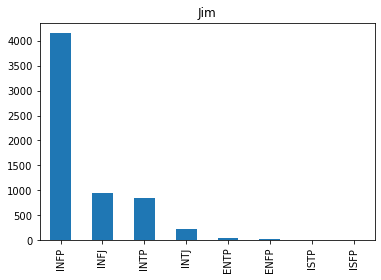

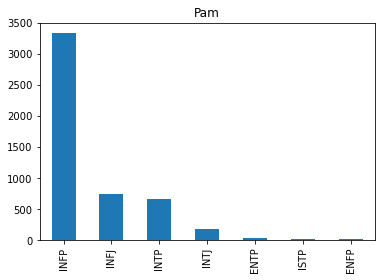

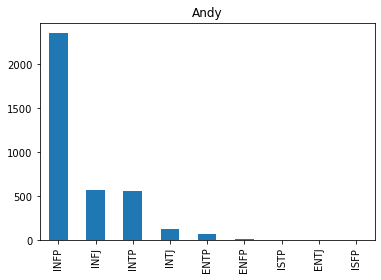

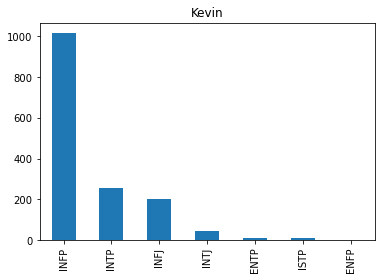

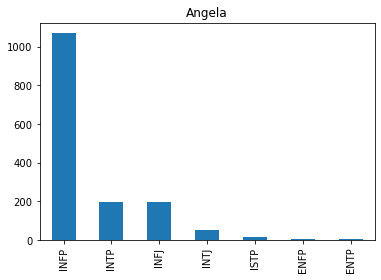

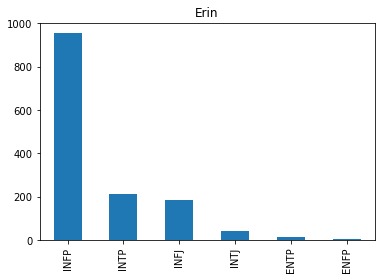

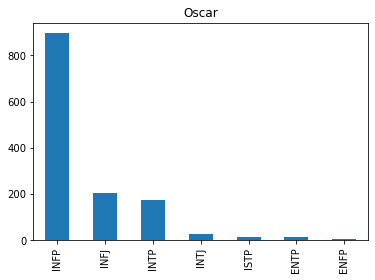

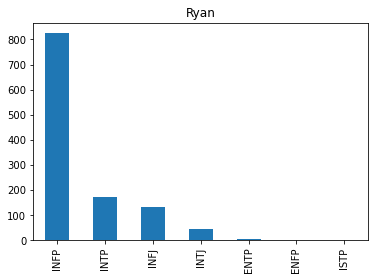

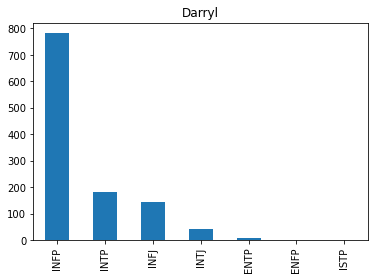

In [68]:
names = ['Michael','Dwight','Jim', 'Pam','Andy','Kevin'
          ,'Angela','Erin','Oscar','Ryan', 'Darryl']
for f in names:
  predictedPj = predictedOfficePjs.loc[predictedOfficePjs['speaker'].isin([f])]
  predictedPj['personalidad'].value_counts().plot(kind = 'bar', title=f)
  plt.show()

In [69]:
cnt_all = np.unique(LogPredictedOffice, return_counts=True)

In [70]:
pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

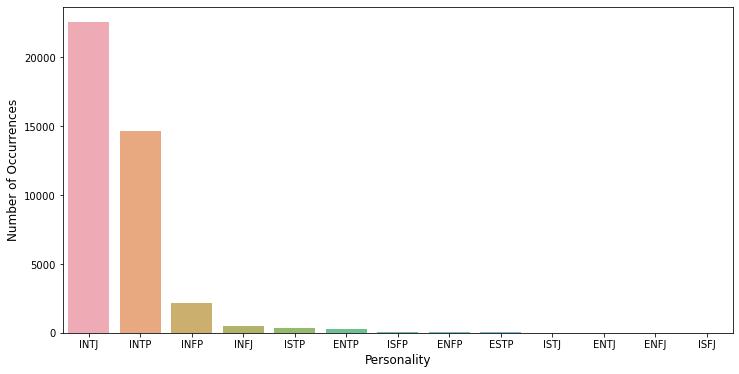

In [71]:
categorias = target_encoder.inverse_transform(pred_df['personality'])
pred_df2 = pred_df
pred_df2['personality'] = target_encoder.inverse_transform(pred_df['personality'])
pred_df2.sort_values('count', ascending=False, inplace=True)
plt.figure(figsize=(12,6))
sns.barplot(pred_df2['personality'], pred_df2['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()